In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8829 - loss: 0.2599 - val_accuracy: 0.9926 - val_loss: 0.0283
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9698 - loss: 0.0738 - val_accuracy: 0.9582 - val_loss: 0.0955
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9793 - loss: 0.0557 - val_accuracy: 0.9053 - val_loss: 0.2791
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9797 - loss: 0.0597 - val_accuracy: 0.9695 - val_loss: 0.0711
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9850 - loss: 0.0403 - val_accuracy: 0.9839 - val_loss: 0.0390
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9861 - loss: 0.0421 - val_accuracy: 0.9881 - val_loss: 0.0329


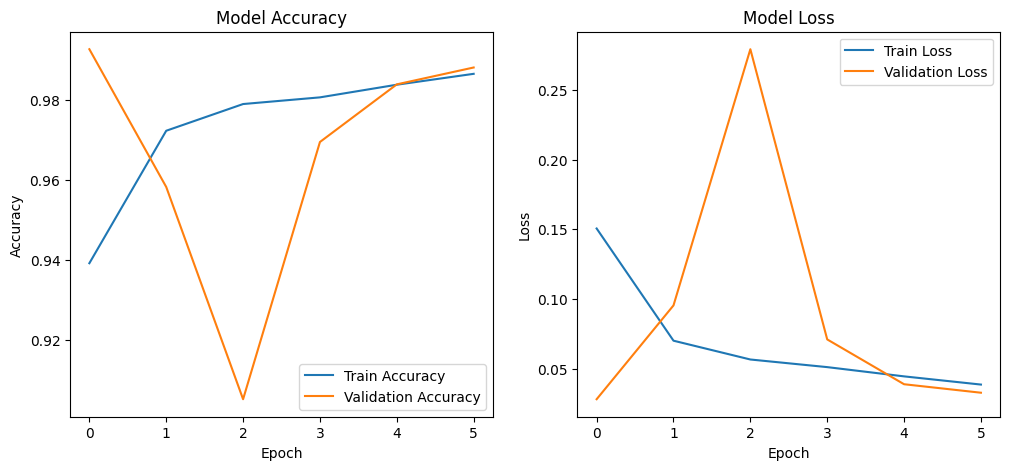

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.1031
Test Accuracy: 94.79%


In [3]:

# 데이터 로드 및 라벨링
def load_and_label_data_from_directory(directory_path):
    data = []
    labels = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            df.columns = [col.replace('_1', '') for col in df.columns]
            label = 1 if 'fall' in filename else 0
            df = df[['ax', 'ay', 'az', 'dpitch', 'droll', 'dyaw', 'w', 'x', 'y', 'z']]
            data.append(df.values)
            labels.extend([label] * len(df))
    return np.vstack(data), np.array(labels)

# 시퀀스 데이터 생성
def create_sequences(data, labels, window_size=50, step=10):
    sequences = []
    seq_labels = []
    for i in range(0, len(data) - window_size, step):
        sequences.append(data[i:i + window_size])
        seq_labels.append(labels[i + window_size])
    return np.array(sequences), np.array(seq_labels)

# 모델 생성
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(200, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 학습 과정 시각화
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()

# 데이터 로드
directory_path = './HR_IMU_merged_csv'
data, labels = load_and_label_data_from_directory(directory_path)

# 학습/테스트 분할
X, y = create_sequences(data, labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# 데이터 정규화
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# SMOTE 적용 (훈련 데이터에만)
n_samples, time_steps, n_features = X_train_scaled.shape
X_train_flat = X_train_scaled.reshape((n_samples, time_steps * n_features))
smote = SMOTE(random_state=27)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape((-1, time_steps, n_features))

# 모델 학습
model = create_model((X_train_resampled.shape[1], X_train_resampled.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 학습 과정 시각화
plot_training_history(history)

# 모델 평가
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
